<a href="https://colab.research.google.com/github/miketibb/DisasterTweets/blob/main/DisasterTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers

In [ ]:
import pandas as pd

pd.read_csv('train.csv').head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
import os
os.chdir('/content/drive/My Drive/Classes-Research/Kaggle/DisasterTweets/')

source_folder = 'Data'
destination_folder = 'Models'

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False,
                   batch_first=True, fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields_tv = [('id', None), ('keyword', text_field), ('location', text_field), ('text', text_field),
             ('target', label_field)] 
fields_test = [('id', None), ('keyword', text_field), ('location', text_field), ('text', text_field)]

train, valid = TabularDataset(path=source_folder + '/train.csv', format='CSV', fields=fields_tv, skip_header=True).split()

test = TabularDataset(path=source_folder + '/test.csv', format='CSV', fields=fields_test, skip_header=True)

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, train=False, shuffle=False, device=device,
                     sort=False)

In [36]:
class BERT(nn.Module):

  def __init__(self):
    super(BERT, self).__init__()

    options_name = "bert-base-uncased"
    self.encoder = BertForSequenceClassification.from_pretrained(options_name)

  def forward(self, text, label=None):
    return self.encoder(text, labels=label)

In [9]:
model = BERT().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [10]:
help(model.encoder)

Help on BertForSequenceClassification in module transformers.models.bert.modeling_bert object:

class BertForSequenceClassification(BertPreTrainedModel)
 |  Bert Model transformer with a sequence classification/regression head on top (a linear layer on top of the pooled
 |  output) e.g. for GLUE tasks.
 |  
 |  
 |  This model inherits from :class:`~transformers.PreTrainedModel`. Check the superclass documentation for the generic
 |  methods the library implements for all its model (such as downloading or saving, resizing the input embeddings,
 |  pruning heads etc.)
 |  
 |  This model is also a PyTorch `torch.nn.Module <https://pytorch.org/docs/stable/nn.html#torch.nn.Module>`__
 |  subclass. Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to
 |  general usage and behavior.
 |  
 |  Parameters:
 |      config (:class:`~transformers.BertConfig`): Model configuration class with all the parameters of the model.
 |          Initializing wi

In [17]:
def save_checkpoint(save_path, model, valid_loss):

  if save_path == None:
    return
  
  state_dict = {'model_state_dict': model.state_dict(),
                'valid_loss': valid_loss}

  torch.save(state_dict, save_path)
  print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):

  if load_path==None:
    return
  
  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')

  model.load_state_dict(state_dict['model_state_dict'])
  return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

  if save_path == None:
      return

  state_dict = {'train_loss_list': train_loss_list,
                'valid_loss_list': valid_loss_list,
                'global_steps_list': global_steps_list}

  torch.save(state_dict, save_path)
  print(f'Model save to ==> {save_path}')


def load_metrics(load_path):
  if load_path == None:
    return

  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')

  return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']



In [37]:
def training(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
  
  #initialize running values
  running_loss = 0.0
  valid_running_loss = 0.0
  global_step = 0
  train_loss_list = []
  valid_loss_list = []
  global_steps_list = []

  #training loop
  model.train()
  for epoch in range(num_epochs):
    for (keyword, location, text, target), _ in train_loader:
      target = target.type(torch.LongTensor)
      target = target.to(device)
      text = text.type(torch.LongTensor)
      text = text.to(device)
      loss = model(text, target).loss

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #update running values
      running_loss += loss.item()
      global_step += 1

      #evaluation step
      if global_step % eval_every == 0:
        model.eval()
        with torch.no_grad():

          #validation loop
          for (keyword, location, text, target), _ in valid_loader:
            target = target.type(torch.LongTensor)
            target = target.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            loss = model(text, target).loss

            valid_running_loss += loss.item()

        #evaluation
        average_train_loss = running_loss / eval_every
        average_valid_loss = valid_running_loss / len(valid_loader)
        train_loss_list.append(average_train_loss)
        valid_loss_list.append(average_valid_loss)
        global_steps_list.append(global_step)

        #resetting running values
        running_loss = 0.0
        valid_running_loss = 0.0
        model.train()

        #print progress
        print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
              .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                      average_train_loss, average_valid_loss))
        
        #checkpoint
        if best_valid_loss > average_valid_loss:
          best_valid_loss = average_valid_loss
          save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
          save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list,
                       global_steps_list)

  save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
  print('Finished Training!')

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

training(model=model, optimizer=optimizer, num_epochs=5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [167/1670], Train Loss: 0.5086, Valid Loss: 0.4721
Model saved to ==> Models/model.pt
Model save to ==> Models/metrics.pt


Model loaded from <== Models/metrics.pt


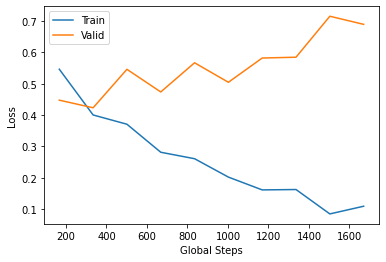

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
#Evaluation Function

def evaluate(model, test_loader):
  y_pred = []
  y_true = []

  model.eval()
  with torch.no_grad():
    for (keyword, location, text, target), _ in test_loader:
      
      target = target.type(torch.LongTensor)
      target = target.to(device)
      text = text.type(torch.LongTensor)
      text = text.to(device)
      output = model(text, target).logits

      y_pred.extend(torch.argmax(output, 1).tolist())
      y_true.extend(target.tolist())

  print('Classification Report:')
  print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

  cm = confusion_matrix(y_true, y_pred, labels=[1,0])
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='d')

  ax.set_title('Confustion Matrix')

  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Lables')

  ax.xaxis.set_ticklabels(['Not Disaster', 'Disaster'])
  ax.yaxis.set_ticklabels(['Not Disaster', 'Disaster'])

In [ ]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, valid_iter)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== Models/model.pt


0.41355078615300306

In [ ]:
import pdb
def predictions(model, test_loader):
  
  id = pd.read_csv(source_folder + '/test.csv', usecols=['id'], squeeze=True)
  y_pred = []

  model.eval()
  with torch.no_grad():
    for (keyword, location, text), _ in test_loader:
      
      text = text.type(torch.LongTensor)
      text = text.to(device)
      output = model(text).logits

      y_pred.extend(torch.argmax(output, 1).tolist())

  data = pd.DataFrame({'id': id, 'target': pd.Series(y_pred)})
  data.to_csv(destination_folder + '/predict.csv', index=False)


predictions(best_model, test_iter)